## PREPARATION

In [1]:
# Reference: https://stackoverflow.com/questions/15514593/importerror-no-module-named-when-trying-to-run-python-script/15622021#15622021
import sys
sys.path.append(r'S:\Grid_Ori_bigdata_005')

In [2]:
import os

import numpy as np
import pandas as pd

import rasterio as rio
import xarray as xr
import rioxarray as rxr

import geopandas as gpd

from rasterio.features import shapes

from sklearn.metrics import mean_squared_error

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_style("ticks") # Ref: https://seaborn.pydata.org/tutorial/aesthetics.html

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec # For creating grid spec

In [3]:
main_dir = r"S:\Grid_Ori_bigdata_005"

---------------------------------------------------------------------------

## VALIDATION

#### 1. Get functions

In [4]:
# Ref: https://gis.stackexchange.com/questions/317391/python-extract-raster-values-at-point-locations
def point_raster_join(pts_df, path):
    '''A function is to get values from raster at the points'''
    coords = [(x, y) for x, y in zip(pts_df.x, pts_df.y)]
    mx_depth = rio.open(path)
    pts_list = [x[0] for x in mx_depth.sample(coords)]
    return pts_list

In [5]:
def get_dict(value_name, iterative_range, filename, observed_df):
    '''A function is to get values from multiple rasters at the points'''
    calibration_dict = {}
    # Looping to get data
    for i in range(len(iterative_range)):
        # Get dataframe
        path = fr"{main_dir}\\n_{n_calibration[i]}\\{filename}"
        calibration_df = observed_df.copy(deep=True)
        calibration_df[f'{value_name}'] = point_raster_join(calibration_df, path)
        calibration_df[f'{value_name}'] = calibration_df[f'{value_name}'].replace(-9999, np.nan)
        calibration_dict[f"n_{n_calibration[i]}"] = calibration_df[['level', f"{value_name}"]]
    return calibration_dict

#### 2. Get observed data

In [6]:
# Get observed data
obs_data_df = gpd.read_file(fr"{main_dir}\2005b_Flood.shp")
# Choose geometry and level
debris_df = obs_data_df[['geometry', 'X', 'Y', 'level_']]
# Rename
debris_df.rename(columns={'X':'x', 'Y':'y', 'level_':'level'}, inplace=True)
# Copy the dataframe and call it validation dataframe
validation_df = debris_df.copy(deep=True)

C:\Users\tmn52\AppData\Local\Temp\ipykernel_9928\4029149510.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  debris_df.rename(columns={'X':'x', 'Y':'y', 'level_':'level'}, inplace=True)


In [7]:
%%time
# Get level from model results
validation_df['mxe'] = point_raster_join(debris_df, fr"{main_dir}\test_nearest\out.mxe")

CPU times: total: 93.8 ms
Wall time: 136 ms


#### 3. Calculate errors

In [8]:
# Calculate the error
validation_df_copy = validation_df.copy(deep=True)
validation_df_copy['error'] = validation_df['mxe'] - validation_df_copy['level']

In [9]:
# Get avarge error and avarage absolute error
print(validation_df_copy['error'].mean())
print(validation_df_copy['error'].abs().mean())

-0.34865627780556696
0.5384687916934492


#### 4. Get plot

In [10]:
# Validate with mxe and rmse
validation_mxe_mse = mean_squared_error(validation_df.level, validation_df.mxe, squared=True)
validation_mxe_rmse = mean_squared_error(validation_df.level, validation_df.mxe, squared=False)

In [11]:
validation_df.mxe

0      2.190
1      2.293
2      3.092
3      2.640
4      1.962
5      3.004
6      3.556
7      4.586
8      4.061
9      4.567
10     5.009
11     6.700
12     6.243
13     6.035
14     9.129
15    15.183
16    12.508
17    11.995
18    14.315
19    17.638
20    18.927
21    19.267
22    19.973
23     4.063
24     3.334
25     3.729
26     3.737
27     4.727
28     2.818
29     4.009
30     4.003
31     4.040
Name: mxe, dtype: float32

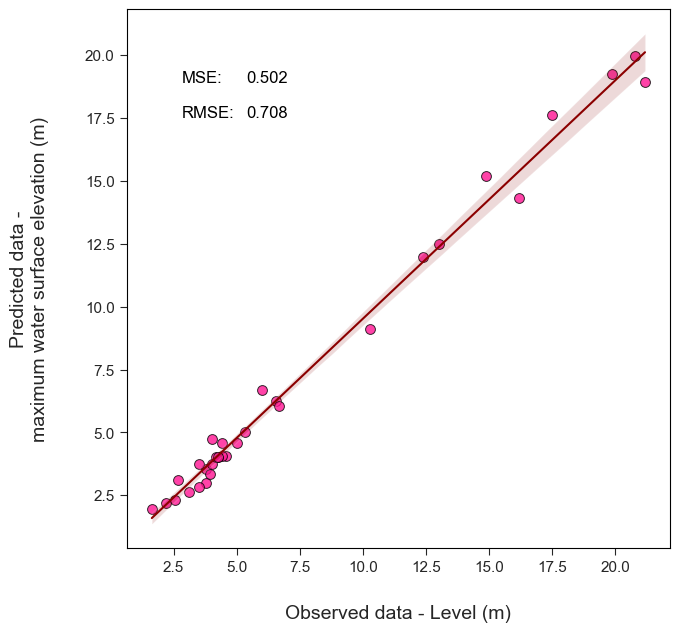

In [12]:
# Plot
fig, ax = plt.subplots(figsize=(7, 7))

# Size for title and label
fontsize = 14
labelpad = 21

# Plot
sns.regplot(x='level', y='mxe', data=validation_df,
            scatter_kws={"s": 50, 'edgecolor': 'black', 'color':'deeppink', 'linewidth':.7},
            line_kws={'color':'darkred', 'linewidth':1.5}, marker='o', ci=95, ax=ax)

# Adjust x and y labels
ax.set_xlabel("Observed data - Level (m)", fontsize=fontsize, labelpad=labelpad)
ax.set_ylabel("Predicted data -\nmaximum water surface elevation (m)", rotation=-270, fontsize=fontsize, labelpad=labelpad+5)

# Set up ticks
ax.set_yticks(np.arange(2.5, 21, 2.5))

# For frame
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    
# Set up ticks
for item in (ax.get_xticklabels() + ax.get_yticklabels()):  # For x, y ticks' labels
    item.set_fontsize(fontsize-3)
ax.tick_params(direction='out', length=5, pad=labelpad-17)
    

title_error = "MSE:\n\nRMSE:"
error = f"{validation_mxe_mse:.3f}\n\n{validation_mxe_rmse:.3f}"

# Error added into the text
# Ref: https://github.com/matplotlib/matplotlib/issues/253/
#      https://stackoverflow.com/questions/67366092/valueerror-alignment-not-allowed-in-string-format-specifier-sometimes-not
#      https://stackoverflow.com/questions/8234445/format-output-string-right-alignment
ax.text(
    .1, .8, # Control the text on the x axis and y axis
    title_error,
    size=fontsize-2, ha='left', color='black', transform=ax.transAxes
)
ax.text(
    .22, .8, # Control the text on the x axis and y axis
    error,
    size=fontsize-2, ha='left', color='black', transform=ax.transAxes
)

plt.savefig(fr"{main_dir}\validation_result.png", bbox_inches='tight', dpi=330)

---------------------------------------------------------------------

## CALIBRATION

#### 1. Get data

In [31]:
# Get range of calibration
n_calibration = np.round(np.arange(0.5, 2.6, 0.1), 1)

In [32]:
%%time
# Get dictionary of calibration results
n_dict = get_dict('mxe', n_calibration, 'out.mxe', debris_df)

CPU times: total: 2.8 s
Wall time: 3.72 s


#### 2. Counting NaNs

In [33]:
# Copy dictionary
import copy
n_dict_copy_001 = copy.deepcopy(n_dict)

In [34]:
# Counting NaNs
num_missing_values = []
for i in range(len(n_calibration)):
    nan_num = n_dict_copy_001[f"n_{n_calibration[i]}"].mxe.isna().sum()
    text = "n = {0} has {1} missing values".format(n_calibration[i], nan_num)
    num_missing_values.append(nan_num)
    print(text)

n = 0.5 has 16 missing values
n = 0.6 has 20 missing values
n = 0.7 has 18 missing values
n = 0.8 has 17 missing values
n = 0.9 has 13 missing values
n = 1.0 has 13 missing values
n = 1.1 has 12 missing values
n = 1.2 has 12 missing values
n = 1.3 has 11 missing values
n = 1.4 has 9 missing values
n = 1.5 has 9 missing values
n = 1.6 has 9 missing values
n = 1.7 has 9 missing values
n = 1.8 has 8 missing values
n = 1.9 has 7 missing values
n = 2.0 has 7 missing values
n = 2.1 has 5 missing values
n = 2.2 has 3 missing values
n = 2.3 has 3 missing values
n = 2.4 has 3 missing values
n = 2.5 has 3 missing values


Text(0, 0.5, 'Missing values')

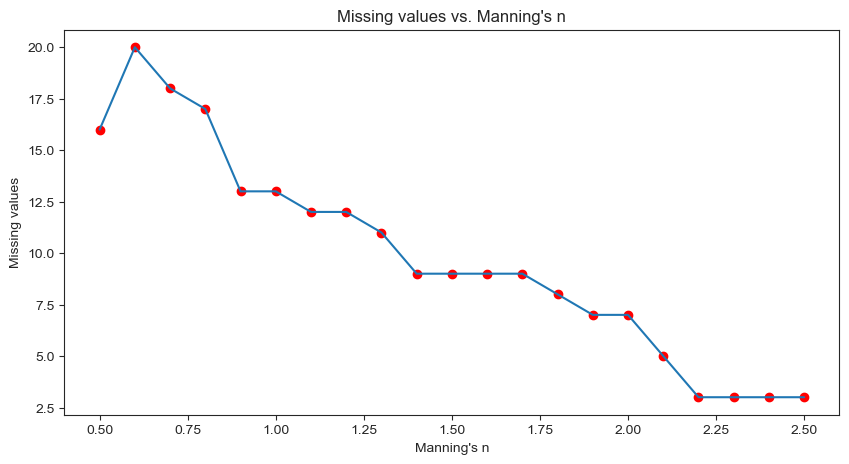

In [35]:
# Plot missing values
fig, ax = plt.subplots(figsize=(10, 5))

ax.scatter(x=n_calibration, y=num_missing_values, c='red')
ax.plot(n_calibration, num_missing_values) # For line
ax.set_title("Missing values vs. Manning's n")
ax.set_xlabel("Manning's n")
ax.set_ylabel("Missing values")

#### 3. Get errors

In [36]:
# Copy dictionary
n_dict_copy_002 = copy.deepcopy(n_dict)

In [37]:
# n_dict_copy_002['n_0.8']

##### First method

In [38]:
n_mxe = pd.DataFrame()
for i in range(len(n_calibration)):
    n_mxe[f'n_mxe_{n_calibration[i]}'] = n_dict_copy_002[f'n_{n_calibration[i]}'].mxe

In [39]:
n_mxe

,n_mxe_0.5,n_mxe_0.6,n_mxe_0.7,n_mxe_0.8,n_mxe_0.9,n_mxe_1.0,n_mxe_1.1,n_mxe_1.2,n_mxe_1.3,n_mxe_1.4,...,n_mxe_1.6,n_mxe_1.7,n_mxe_1.8,n_mxe_1.9,n_mxe_2.0,n_mxe_2.1,n_mxe_2.2,n_mxe_2.3,n_mxe_2.4,n_mxe_2.5
0,1.865,NaN,1.871000,1.989,2.096000,2.172,2.239000,2.299,2.358,2.415000,...,2.524000,2.571000,2.613000,2.649000,2.680000,2.708000,2.733000,2.756,2.777000,2.799000
1,1.975,1.830000,1.974000,2.092,2.198000,2.279,2.345000,2.406,2.467,2.526000,...,2.635000,2.682000,2.724000,2.761000,2.793000,2.821000,2.846000,2.868,2.890000,2.912000
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.315,2.132000,2.285000,2.415,2.534000,2.628,2.703000,2.772,2.840,2.906000,...,3.026000,3.078000,3.124000,3.164000,3.199000,3.230000,3.258000,3.284,3.308000,3.333000
4,NaN,NaN,NaN,NaN,1.872000,1.946,2.011000,2.071,2.130,2.188000,...,2.293000,2.339000,2.379000,2.413000,2.443000,2.469000,2.493000,2.515,2.537000,2.558000
5,2.655,2.447000,2.612000,2.755,2.887000,2.992,3.076000,3.152,3.229,3.305000,...,3.441000,3.499000,3.551000,3.597000,3.637000,3.672000,3.702000,3.728,3.751000,3.774000
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.604000,3.651000,3.691000,3.726000,3.757000,3.783,3.807000,3.830000
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4.631000,4.668000,4.700000,4.728000,4.752,4.773000,4.791000
8,3.961,3.566000,3.706000,3.833,3.954000,4.051,4.131000,4.201,4.277,4.352000,...,4.484000,4.541000,4.590000,4.634000,4.673000,4.706000,4.734000,4.758,4.780000,4.799000
9,5.103,4.004000,4.158000,4.301,4.444000,4.557,4.651000,4.733,4.812,4.897000,...,5.056000,5.125000,5.188000,5.243000,5.292000,5.335000,5.372000,5.405,5.433000,5.458000


In [40]:
# # Get indices of nan rows
# nan_inds = pd.isnull(n_mxe).any(1).to_numpy().nonzero()

In [41]:
# Get indices of not nan rows
notnan_inds = pd.notnull(n_mxe).all(1).to_numpy().nonzero()
# Convert to list
notnan_inds_list = np.array(notnan_inds).tolist()[0]

In [42]:
# Get no missing data dictionary
n_nomissing_dict = {}
for i in range(len(n_calibration)):
    n_nomissing_dict[f"n_{n_calibration[i]}"] = n_dict_copy_002[f"n_{n_calibration[i]}"].loc[notnan_inds_list, :]

In [43]:
# Generate RMSE without missing values
rmse_selectedmissing_list = []
for i in range(len(n_calibration)):
    rmse = mean_squared_error(
        n_nomissing_dict[f"n_{n_calibration[i]}"].level, 
        n_nomissing_dict[f"n_{n_calibration[i]}"].mxe, 
        squared=False
    )
    rmse_selectedmissing_list.append(rmse)
    text = "RMSE when n = {0} is {1:.3f}".format(n_calibration[i], rmse_selectedmissing_list[i])
    print(text)

RMSE when n = 0.5 is 0.875
RMSE when n = 0.6 is 1.123
RMSE when n = 0.7 is 0.995
RMSE when n = 0.8 is 0.880
RMSE when n = 0.9 is 0.776
RMSE when n = 1.0 is 0.693
RMSE when n = 1.1 is 0.624
RMSE when n = 1.2 is 0.565
RMSE when n = 1.3 is 0.514
RMSE when n = 1.4 is 0.472
RMSE when n = 1.5 is 0.442
RMSE when n = 1.6 is 0.425
RMSE when n = 1.7 is 0.421
RMSE when n = 1.8 is 0.427
RMSE when n = 1.9 is 0.440
RMSE when n = 2.0 is 0.459
RMSE when n = 2.1 is 0.481
RMSE when n = 2.2 is 0.505
RMSE when n = 2.3 is 0.530
RMSE when n = 2.4 is 0.556
RMSE when n = 2.5 is 0.581


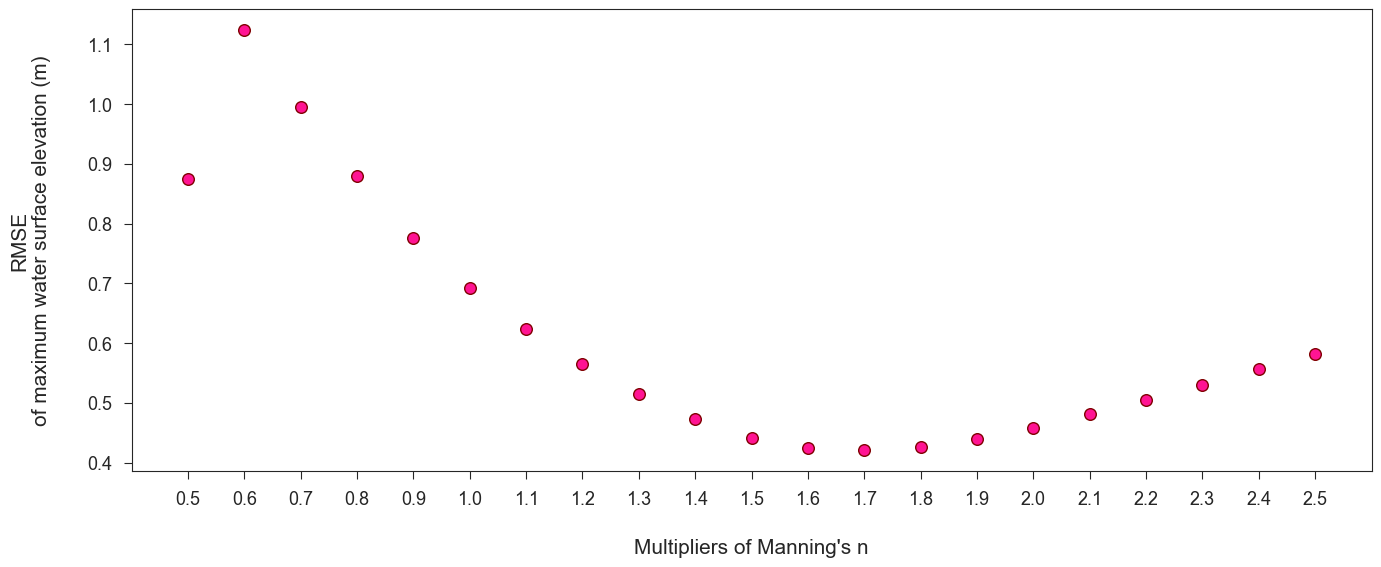

In [44]:
# No connected lines
fig, ax = plt.subplots(figsize=(16, 6))

fontsize = 15
labelpad = 21

# Plot
ax.scatter(x=n_calibration, y=rmse_selectedmissing_list, 
           facecolor='deeppink', edgecolor='maroon', linewidth=1, s=70, zorder=2)

# Set up ticks
ax.set_xticks(np.arange(.5, 2.6, .1))
# ax.set_yticks(np.arange(.3, 1, .1))

# # Set up x limit
# ax.set_ylim(bottom=.37)

# Adjust x and y labels
ax.set_xlabel("Multipliers of Manning's n", fontsize=fontsize, labelpad=labelpad)
ax.set_ylabel("RMSE\nof maximum water surface elevation (m)", rotation=-270, fontsize=fontsize, labelpad=labelpad+5)

    
# Set up ticks
for item in (ax.get_xticklabels() + ax.get_yticklabels()):  # For x, y ticks' labels
    item.set_fontsize(fontsize-2)
ax.tick_params(direction='out', length=labelpad-15, pad=labelpad-13)

# Save
plt.savefig(fr"{main_dir}\calibration_noconnectedline.png", bbox_inches='tight', dpi=330)

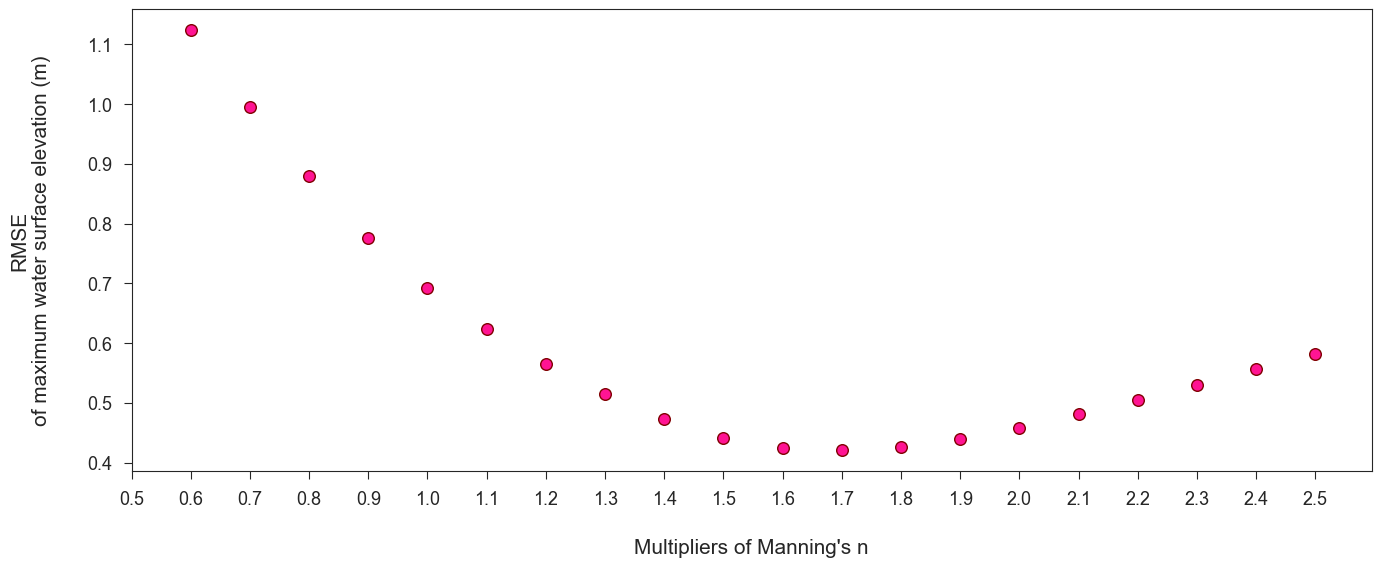

In [58]:
# No connected lines
fig, ax = plt.subplots(figsize=(16, 6))

fontsize = 15
labelpad = 21

# Plot
ax.scatter(x=n_calibration[1:], y=rmse_selectedmissing_list[1:], 
           facecolor='deeppink', edgecolor='maroon', linewidth=1, s=70, zorder=2)

# Set up ticks
ax.set_xticks(np.arange(.5, 2.6, .1))
# ax.set_yticks(np.arange(.3, 1, .1))

# # Set up x limit
# ax.set_ylim(bottom=.37)

# Adjust x and y labels
ax.set_xlabel("Multipliers of Manning's n", fontsize=fontsize, labelpad=labelpad)
ax.set_ylabel("RMSE\nof maximum water surface elevation (m)", rotation=-270, fontsize=fontsize, labelpad=labelpad+5)

    
# Set up ticks
for item in (ax.get_xticklabels() + ax.get_yticklabels()):  # For x, y ticks' labels
    item.set_fontsize(fontsize-2)
ax.tick_params(direction='out', length=labelpad-15, pad=labelpad-13)

# Save
plt.savefig(fr"{main_dir}\calibration_noconnectedline.png", bbox_inches='tight', dpi=330)

##### Second method

In [52]:
# Get no missing data dictionary
n_nomissing_dict = {}
for i in range(len(n_calibration)):
    n_nomissing_dict[f"n_{n_calibration[i]}"] = n_dict_copy_002[f"n_{n_calibration[i]}"][n_dict_copy_002['n_0.6'].mxe.notnull()]

In [53]:
# Generate RMSE without missing values
rmse_selectedmissing_list = []
for i in range(len(n_calibration)):
    rmse = mean_squared_error(
        n_nomissing_dict[f"n_{n_calibration[i]}"][n_nomissing_dict[f"n_{n_calibration[i]}"].mxe.notnull()].level, 
        n_nomissing_dict[f"n_{n_calibration[i]}"][n_nomissing_dict[f"n_{n_calibration[i]}"].mxe.notnull()].mxe, 
        squared=False
    )
    rmse_selectedmissing_list.append(rmse)
    text = "RMSE when n = {0} is {1:.3f}".format(n_calibration[i], rmse_selectedmissing_list[i])
    print(text)

RMSE when n = 0.5 is 0.875
RMSE when n = 0.6 is 1.123
RMSE when n = 0.7 is 0.995
RMSE when n = 0.8 is 0.880
RMSE when n = 0.9 is 0.776
RMSE when n = 1.0 is 0.693
RMSE when n = 1.1 is 0.624
RMSE when n = 1.2 is 0.565
RMSE when n = 1.3 is 0.514
RMSE when n = 1.4 is 0.472
RMSE when n = 1.5 is 0.442
RMSE when n = 1.6 is 0.425
RMSE when n = 1.7 is 0.421
RMSE when n = 1.8 is 0.427
RMSE when n = 1.9 is 0.440
RMSE when n = 2.0 is 0.459
RMSE when n = 2.1 is 0.481
RMSE when n = 2.2 is 0.505
RMSE when n = 2.3 is 0.530
RMSE when n = 2.4 is 0.556
RMSE when n = 2.5 is 0.581


In [54]:
# # Connected line
# fig, ax = plt.subplots(figsize=(16, 6))

# fontsize = 15
# labelpad = 21

# # Plot
# # Line
# ax.plot(n_calibration, rmse_selectedmissing_list, c='deeppink') # For line
# # Points
# ax.scatter(x=n_calibration, y=rmse_selectedmissing_list, 
#            facecolor='maroon', edgecolor='white', linewidth=1, s=70, zorder=2)

# # Set up ticks
# ax.set_xticks(np.arange(.5, 2.6, .1))
# ax.set_yticks(np.arange(.3, 1, .1))

# # Set up x limit
# ax.set_ylim(bottom=.37)

# # Adjust x and y labels
# ax.set_xlabel("Multipliers of Manning's n", fontsize=fontsize, labelpad=labelpad)
# ax.set_ylabel("RMSE\nof maximum water surface elevation (m)", rotation=-270, fontsize=fontsize, labelpad=labelpad+5)

    
# # Set up ticks
# for item in (ax.get_xticklabels() + ax.get_yticklabels()):  # For x, y ticks' labels
#     item.set_fontsize(fontsize-2)
# ax.tick_params(direction='out', length=labelpad-15, pad=labelpad-13)

# # Save
# plt.savefig(fr"{main_dir}\calibration_connectedline.png", bbox_inches='tight', dpi=330)

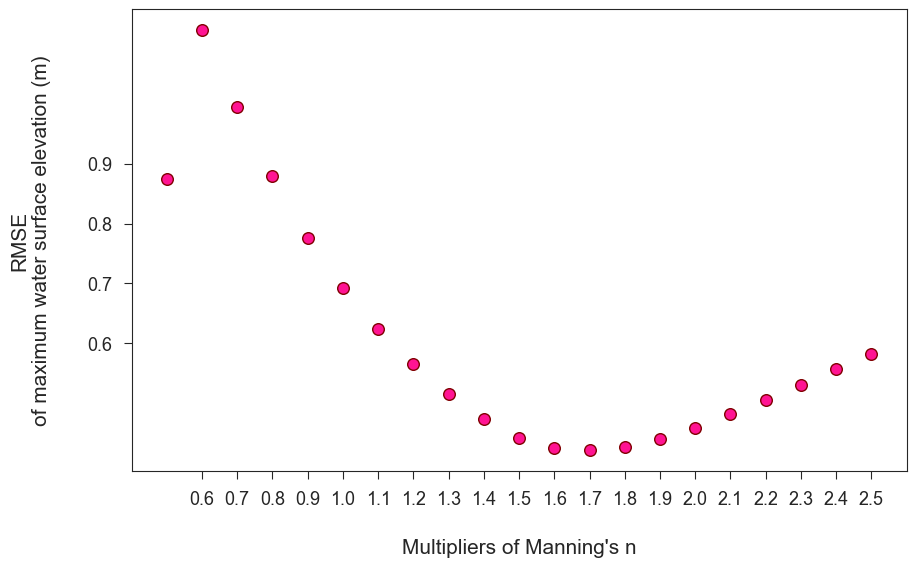

In [55]:
# No connected lines
fig, ax = plt.subplots(figsize=(10, 6))

fontsize = 15
labelpad = 21

# Plot
ax.scatter(x=n_calibration, y=rmse_selectedmissing_list, 
           facecolor='deeppink', edgecolor='maroon', linewidth=1, s=70, zorder=2)

# Set up ticks
ax.set_xticks(np.arange(.6, 2.6, .1))
ax.set_yticks(np.arange(.6, 1, .1))

# # Set up x limit
# ax.set_ylim(bottom=.37)

# Adjust x and y labels
ax.set_xlabel("Multipliers of Manning's n", fontsize=fontsize, labelpad=labelpad)
ax.set_ylabel("RMSE\nof maximum water surface elevation (m)", rotation=-270, fontsize=fontsize, labelpad=labelpad+5)

    
# Set up ticks
for item in (ax.get_xticklabels() + ax.get_yticklabels()):  # For x, y ticks' labels
    item.set_fontsize(fontsize-2)
ax.tick_params(direction='out', length=labelpad-15, pad=labelpad-13)

# Save
plt.savefig(fr"{main_dir}\calibration_noconnectedline.png", bbox_inches='tight', dpi=330)